# Likelihood contours from the Fisher Matrix

In this notebook we show how to get likelihood contours from the Fisher matrix.  We use the same toy astronomical stellar spectrum model as demos 1 and 2.  We have observed **D**ata and a tunable **M**odel.

$$\mathsf{M(\vec{\theta})} = f_\lambda(T_{\mathrm{eff}}, \log{g}, [\mathrm{Fe}/{\mathrm{H}}])$$

$$\mathsf{D} = f_\lambda + \epsilon$$

where $\epsilon$ is normally distributed Gaussian white noise with standard deviation $\sigma$.

The residual spectrum is then:  
$$ \mathsf{R} = \mathsf{D} - \mathsf{M}  $$

We want to find the permutation of parameters that gives the lowest **sum of the squares of the residuals**.

$\chi^2 \propto \sum_i^N \frac{R_i^2}{\sigma}$

The goal of this notebook is to show that we can use the Fisher matrix to get the chi-squared minimum.  Here is a paper that describes how to use the Fisher matrix to achieve this goal:

https://arxiv.org/abs/0906.4123

The first step is to **override** numpy with a version that tracks the instruction set of primitive functions, and applies the chain rule to their derivatives.  We'll use [jax](https://github.com/google/jax).

In [1]:
#import numpy as np
import jax.numpy as np

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The data exist as a table of wavelength, flux, and flux uncertainty.  
You can think of the wavelength values as corresponding to the near-IR in micron.

In [3]:
wl = np.linspace(2.0, 2.4, 10000)

/Users/obsidian/anaconda3/envs/TgiF/lib/python3.7/site-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


The spectral lines will all be absorption lines with Gaussian line profiles:
$$ $$
$$\mathrm{abs}(\lambda) = A \cdot e^{-\frac{1}{2}\left((\lambda-\lambda_0)/\sigma\right)^2 }$$

The free paramters for the line are the line center position $\lambda_0$, depth $A$, and linewidth $\sigma$.

In [4]:
def line_profile(location, depth, width):
    """Make a spectral line"""
    return depth * np.exp(-0.5*((wl-location)/width)**2)

We're going to make a function that generates fake flux values.
This spectrum has 3 distinct lines:  
- $\lambda=2.1$ the amplitude depends only on $T_{\mathrm{eff}}$
- $\lambda=2.2$ the linewidth depends only on $\log{g}$
- $\lambda=2.3$ increases linearly with $[\mathrm{Fe}/\mathrm{H}]$

In [5]:
def synthetic_spectrum(a):
    """generate a synthetic spectrum"""
    teff, logg, fe_h = a 
    
    amp1 = 0.6*np.exp(-((teff-2700)/500)**2)
    width1 = 0.02 - 0.002*(0.5+np.arctan( ((logg - 3.5)/0.8) / (np.pi/4) ))
    line1 = line_profile(2.1, amp1, width1)
    
    width2 = 0.01 + 0.002*(0.5+np.arctan( ((logg - 3)/0.5) / (np.pi/4) ))
    line2 = line_profile(2.2, 0.3, width2)
    
    amp3 = 0.0 + 0.1*np.sqrt(6+fe_h)
    line3 = line_profile(2.3, amp3, 0.01)
    
    net_flux = 1 - (line1 + line2 + line3)
    return net_flux

Next step: use jax to get: 
$$\frac{\partial f_\lambda}{\partial T_{\mathrm{eff} }}, \frac{\partial f_\lambda}{\partial \log{g}}, \frac{\partial f_\lambda}{\partial [\mathrm{Fe}/\mathrm{H}]}$$

In [6]:
from jax import grad, jit, vmap, jacfwd, jacrev

In [7]:
%time 
forward_mode_jacobian = jacfwd(synthetic_spectrum)((2700.0, 3.5, 0.0))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


In [8]:
labels = [r'$\frac{\partial f_\lambda}{\partial T_{\mathrm{eff} }}$',
          r'$\frac{\partial f_\lambda}{\partial \log{g}}$',
          r'$\frac{\partial f_\lambda}{\partial [\mathrm{Fe}/\mathrm{H}]}$']

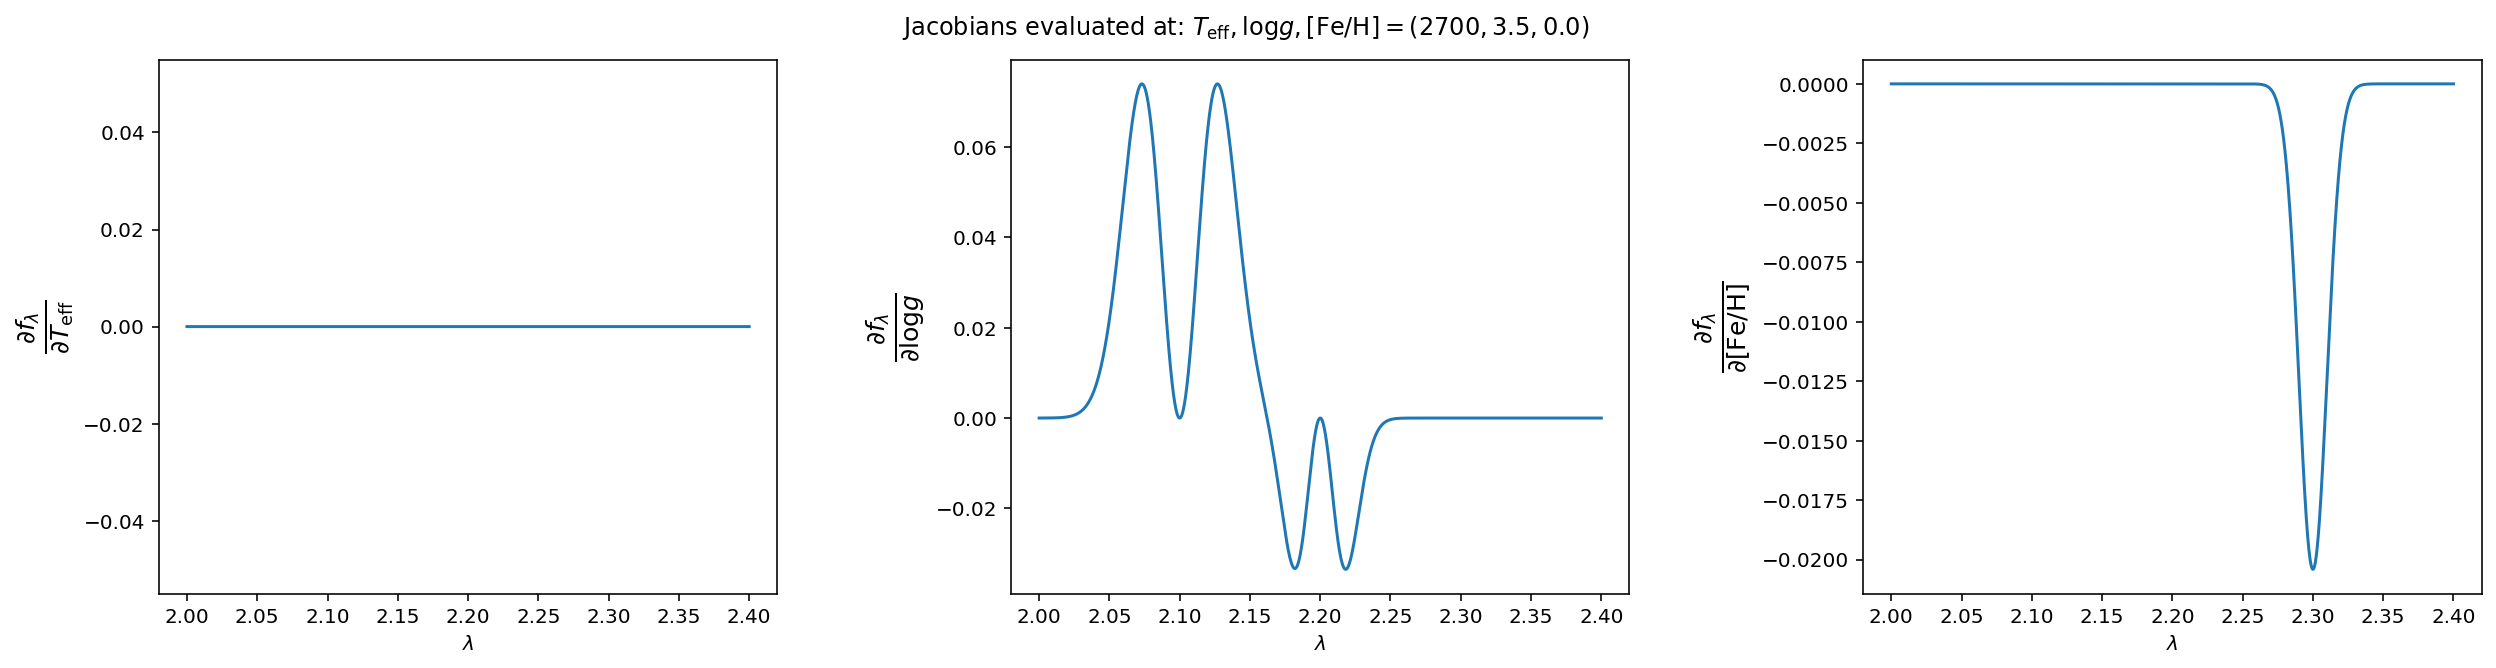

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, partial_derivative in enumerate(forward_mode_jacobian): 
    axes[i].plot(wl,partial_derivative, label = labels[i]);
    axes[i].set_xlabel('$\lambda$'); axes[i].set_ylabel(labels[i], fontsize=18) 
fig.suptitle('Jacobians evaluated at: $T_{\mathrm{eff}}, \log{g}, [\mathrm{Fe}/{\mathrm{H}}] = (2700, 3.5, 0.0)$')
plt.tight_layout(pad=3);

Awesome!  We computed exact Jacobians instantly!  Each plot shows the partial derivative of the spectrum with respect to a stellar parameter.

In [10]:
flux = synthetic_spectrum((2700, 3.5, 0.0))

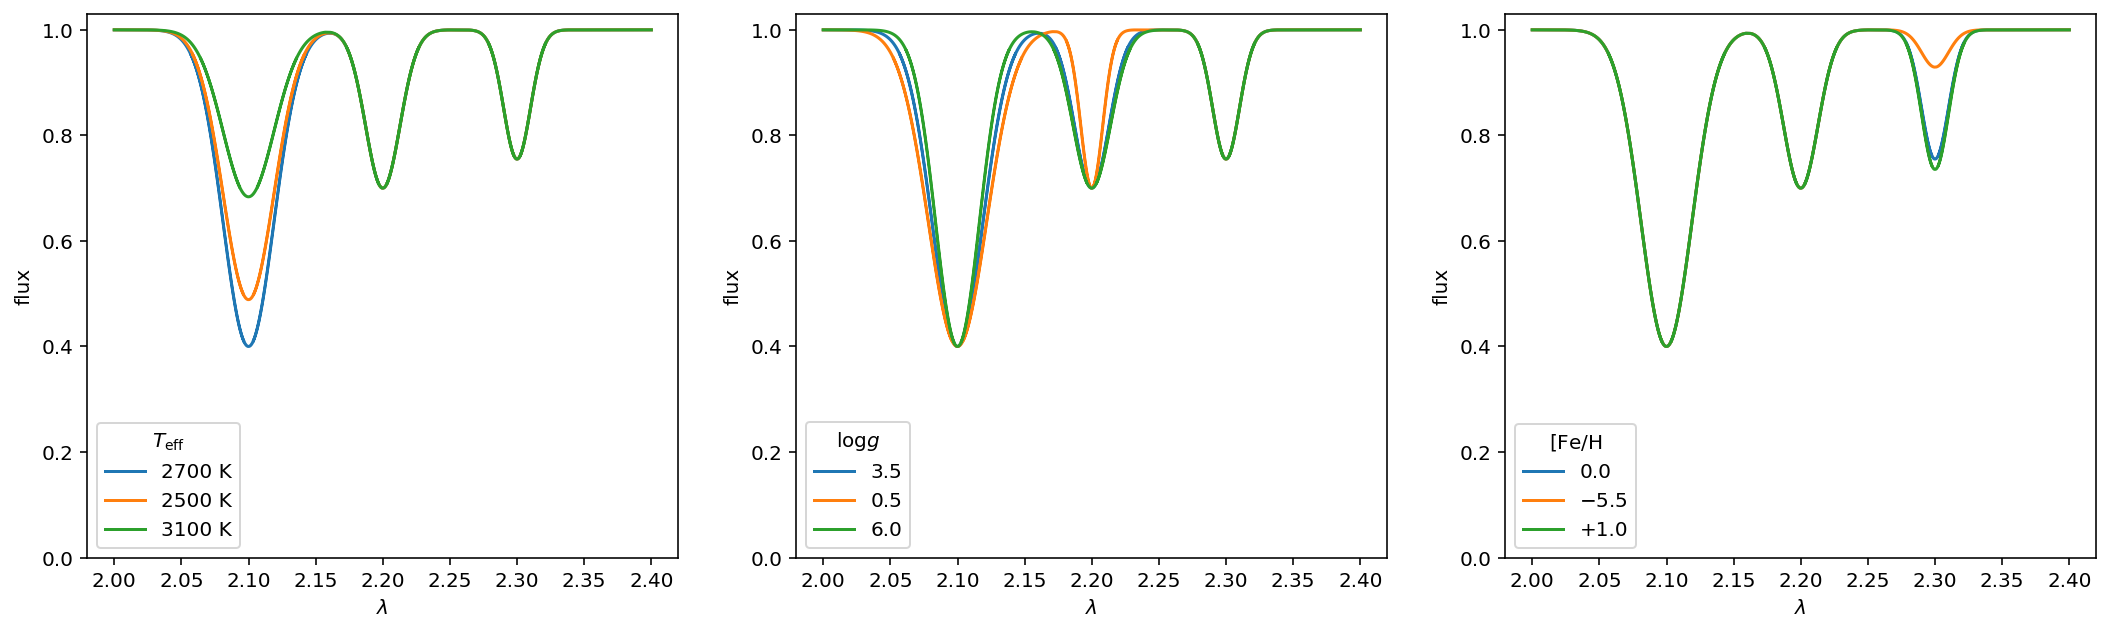

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))


axes[0].step(wl, flux, label='2700 K');
axes[0].step(wl, synthetic_spectrum((2500, 3.5, 0.0)), label='2500 K')
axes[0].step(wl, synthetic_spectrum((3100, 3.5, 0.0)), label='3100 K')
axes[0].set_xlabel('$\lambda$'); axes[0].set_ylabel('flux');axes[0].legend(loc='best', title='$T_{\mathrm{eff}}$');axes[0].set_ylim(0);

axes[1].step(wl, flux, label='3.5');
axes[1].step(wl, synthetic_spectrum((2700, 0.5, 0.0)), label='0.5')
axes[1].step(wl, synthetic_spectrum((2700, 6.0, 0.0)), label='6.0')
axes[1].set_xlabel('$\lambda$'); axes[1].set_ylabel('flux');axes[1].legend(loc='best', title='$\log{g}$');axes[1].set_ylim(0);


axes[2].step(wl, flux, label='0.0');
axes[2].step(wl, synthetic_spectrum((2700, 3.5, -5.5)), label='$-5.5$')
axes[2].step(wl, synthetic_spectrum((2700, 3.5, 1.0)), label='+1.0')
axes[2].set_xlabel('$\lambda$'); axes[2].set_ylabel('flux');axes[2].legend(loc='best', title='$[\mathrm{Fe}/\mathrm{H}$');axes[2].set_ylim(0);

## Generate synthetic (*i.e.* `fake`) data

Let's generates some *fake data*, and attempt to fit the data with MCMC.  We expect to see degeneracies.

In [12]:
import numpy as np_original

In [13]:
true_parameters = (3217.0, 4.77, -1.62)

The observation will have a coarser wavelength sampling:

In [14]:
wl = np.linspace(2.0, 2.4, 200)

In [15]:
noiseless_signal = synthetic_spectrum(true_parameters)

In [16]:
sigma = 0.01
noise = np_original.random.normal(0, sigma, size=len(noiseless_signal))

In [17]:
fake_data = noiseless_signal + noise

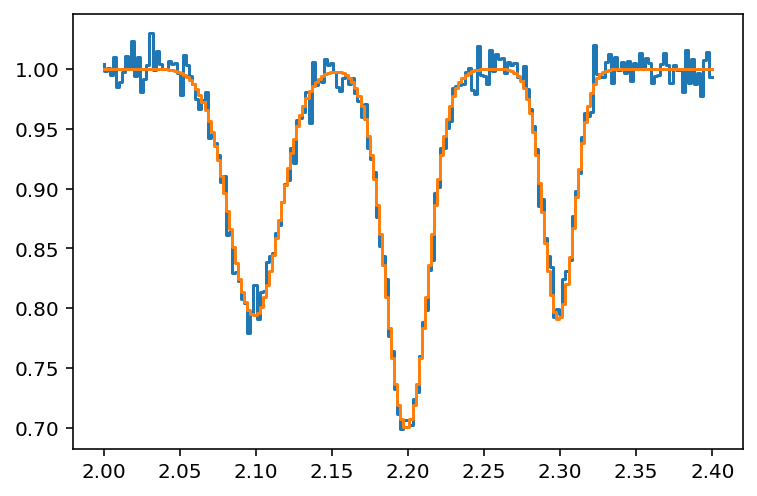

In [18]:
plt.step(wl, fake_data);
plt.step(wl, noiseless_signal);

Construct a chi square **Likelihood function**: $\mathcal{L}$.

We want to compute

$$\frac{\partial \mathcal{L}}{\partial T_{\mathrm{eff} }}, \frac{\partial \mathcal{L}}{\partial \log{g}}, \frac{\partial \mathcal{L}}{\partial [\mathrm{Fe}/\mathrm{H}]}$$

In [19]:
def log_likelihood(theta):
    model = synthetic_spectrum(theta)
    residuals = model - fake_data
    log_like = -0.5*np.sum(residuals**2/sigma**2)
    return log_like

In [20]:
def chi_squared(theta):
    return -1*log_likelihood(theta)

In [21]:
initial_guess = (3300.0, 4.5, 0.0)

In [22]:
this_gradient_vector = jacrev(chi_squared)(initial_guess)

This should be a 3-element vector:

In [23]:
this_gradient_vector 

(DeviceArray(6.384116, dtype=float32),
 DeviceArray(32.18605, dtype=float32),
 DeviceArray(80.573235, dtype=float32))

We can get the chi-squared minimum (aka Maximum Likelihood Estimate or MLE), with scipy minimize:

In [24]:
from scipy.optimize import minimize

In [25]:
%%time
result = minimize(chi_squared, initial_guess, jac=jacrev(chi_squared))

CPU times: user 5.1 s, sys: 1.03 s, total: 6.13 s
Wall time: 4.55 s


We'll save the best fit **MLE** for later.

In [26]:
mle_estimate = result.x

Let's get the Hessian, which is a matrix with these elements:

$$\frac{\partial^2 \mathcal{L}}{\partial T^2_{\mathrm{eff} }} \quad \frac{\partial^2 \mathcal{L}}{\partial \log{g} \, \partial T_{\mathrm{eff} }}\quad \frac{\partial^2 \mathcal{L}}{\partial [\mathrm{Fe}/\mathrm{H}] \, \partial T_{\mathrm{eff} } }$$

$$\frac{\partial^2 \mathcal{L}}{\partial T_{\mathrm{eff}} \, \partial \log{g}}\quad \frac{\partial^2 \mathcal{L}}{\partial \log{g}^2}\quad \frac{\partial^2 \mathcal{L}}{\partial [\mathrm{Fe}/\mathrm{H}] \, \partial \log{g}}$$

$$\frac{\partial^2 \mathcal{L}}{\partial T_{\mathrm{eff}} \, \partial [\mathrm{Fe}/\mathrm{H}]}\quad \frac{\partial^2 \mathcal{L}}{\partial \log{g} \, \partial [\mathrm{Fe}/\mathrm{H}]}\quad \frac{\partial^2 \mathcal{L}}{\partial [\mathrm{Fe}/\mathrm{H}]^2}$$

In [27]:
this_Hessian_matrix = jacfwd(jacrev(log_likelihood))(mle_estimate)

In [28]:
import seaborn as sns

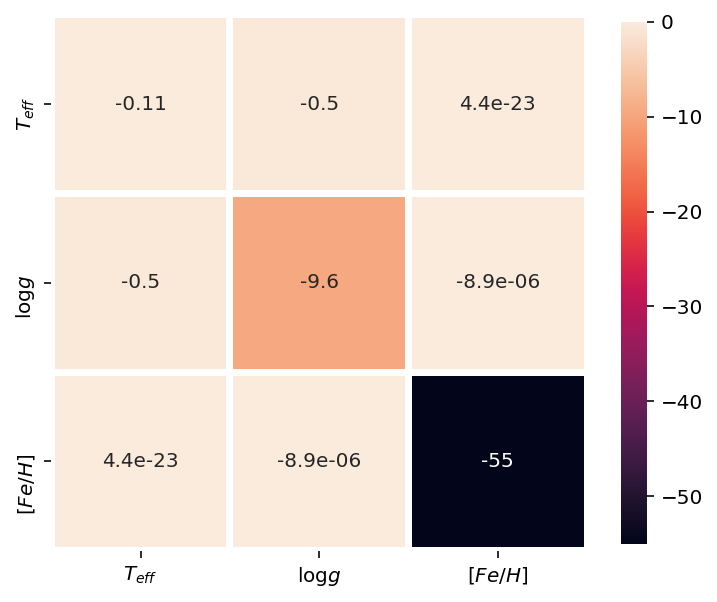

In [29]:
fig, ax = plt.subplots(figsize=(6,6))
labels=['$T_{eff}$', '$\log{g}$', '$[Fe/H]$']
sns.heatmap(this_Hessian_matrix, square=True, ax=ax, xticklabels=labels, 
            yticklabels=labels, cbar_kws={"shrink": 0.8}, linewidths=3, annot=True);

The Fisher matrix is the inverse of the Hessian times $-1$:

In [30]:
matrix_Hessian_inverse = np.linalg.inv(np.array(this_Hessian_matrix))

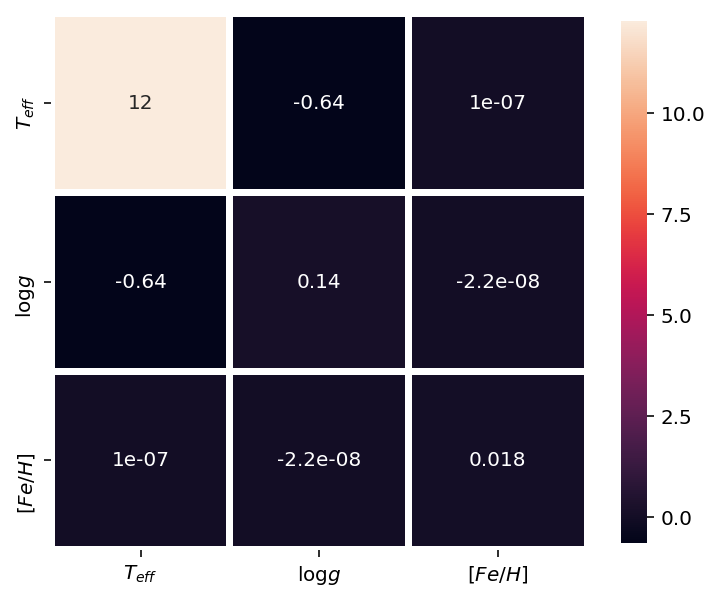

In [31]:
fig, ax = plt.subplots(figsize=(6,6))
labels=['$T_{eff}$', '$\log{g}$', '$[Fe/H]$']
sns.heatmap(-1*matrix_Hessian_inverse, square=True, ax=ax, xticklabels=labels, 
            yticklabels=labels, cbar_kws={"shrink": 0.8}, linewidths=3, annot=True)

The values have different physical units making the scale go off the chart for temperature.  The standard errors are the square roots of the diagonal.

In [32]:
fisher_matrix = -1*matrix_Hessian_inverse

In [33]:
standard_errors = np.sqrt(np.diag(fisher_matrix))
standard_errors

DeviceArray([3.5047138 , 0.37014693, 0.13482721], dtype=float32)

Let's view the upper $2\times2$ projection, which is likely to be correlated due to multiple physical effects contributing to the same spectral line.   
We will draw likelihood contours based on this covariance matrix, taking the code from [this plotting example in astroML](https://github.com/astroML/astroML/blob/master/astroML/plotting/tools.py).  Thanks Jake Vanderplas!

In [34]:
from matplotlib.patches import Ellipse

In [35]:
def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                             (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse((mu[0], mu[1]),
                             2 * scale * sigma1, 2 * scale * sigma2,
                             alpha * 180. / np.pi,
                             **kwargs))

In [36]:
mean = mle_estimate[0:2]
cov = -1*matrix_Hessian_inverse[0:2, 0:2]

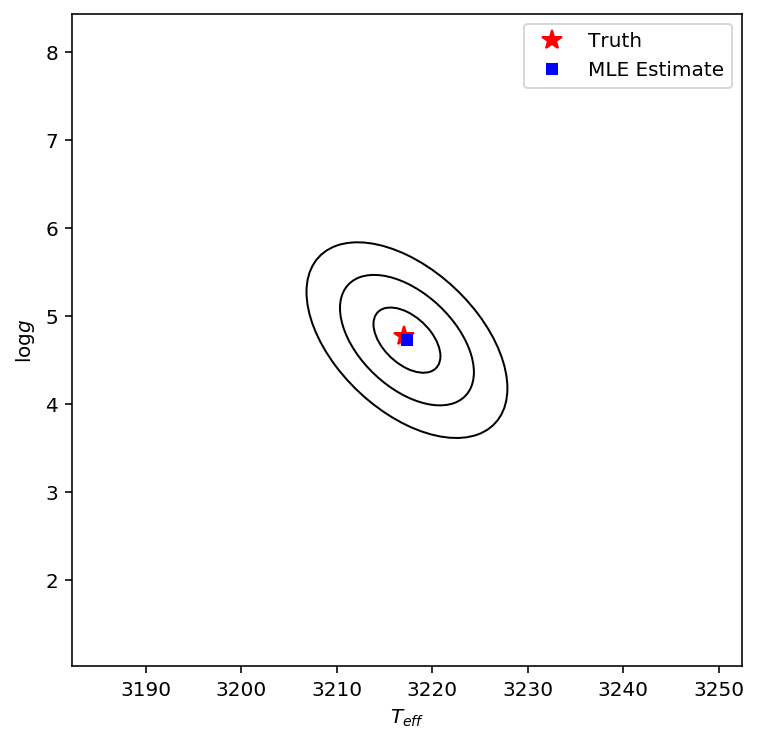

In [37]:
fig, ax = plt.subplots(figsize=(6,6))
plt.plot([true_parameters[0]], [true_parameters[1]], 'r*', ms=10, label = 'Truth')
plt.plot([mle_estimate[0]], [mle_estimate[1]], 'bs', ms=5, label = 'MLE Estimate')
draw_ellipse(mean, cov, ax=ax, fc='none', ec='k', zorder=10)
plt.xlim(mean[0]-standard_errors[0]*10, mean[0]+standard_errors[0]*10)
plt.ylim(mean[1]-standard_errors[1]*10, mean[1]+standard_errors[1]*10)
plt.xlabel("$T_{eff}$")
plt.ylabel("$\log{g}$")
plt.legend();

Awesome!! Let's compare that to a grid search over likelihood!

In [38]:
n_teffs, n_loggs = 100, 150
teff_vals = np_original.linspace(3200, 3250, n_teffs)
logg_vals = np_original.linspace(2, 7, n_loggs)
likelihood_grid = np_original.zeros((n_teffs, n_loggs)) # we don't need Jax here

In [39]:
from tqdm import tqdm

This step takes about 90 seconds:

In [40]:
for i, teff in tqdm(enumerate(teff_vals), total=n_teffs):
    for j, logg in enumerate(logg_vals):
        likelihood_grid[i,j] = log_likelihood((teff, logg, mle_estimate[-1]))

100%|██████████| 100/100 [01:40<00:00,  1.01s/it]


We will compare the True value and its Hessian-based contours to the evaluated likelihood surface.

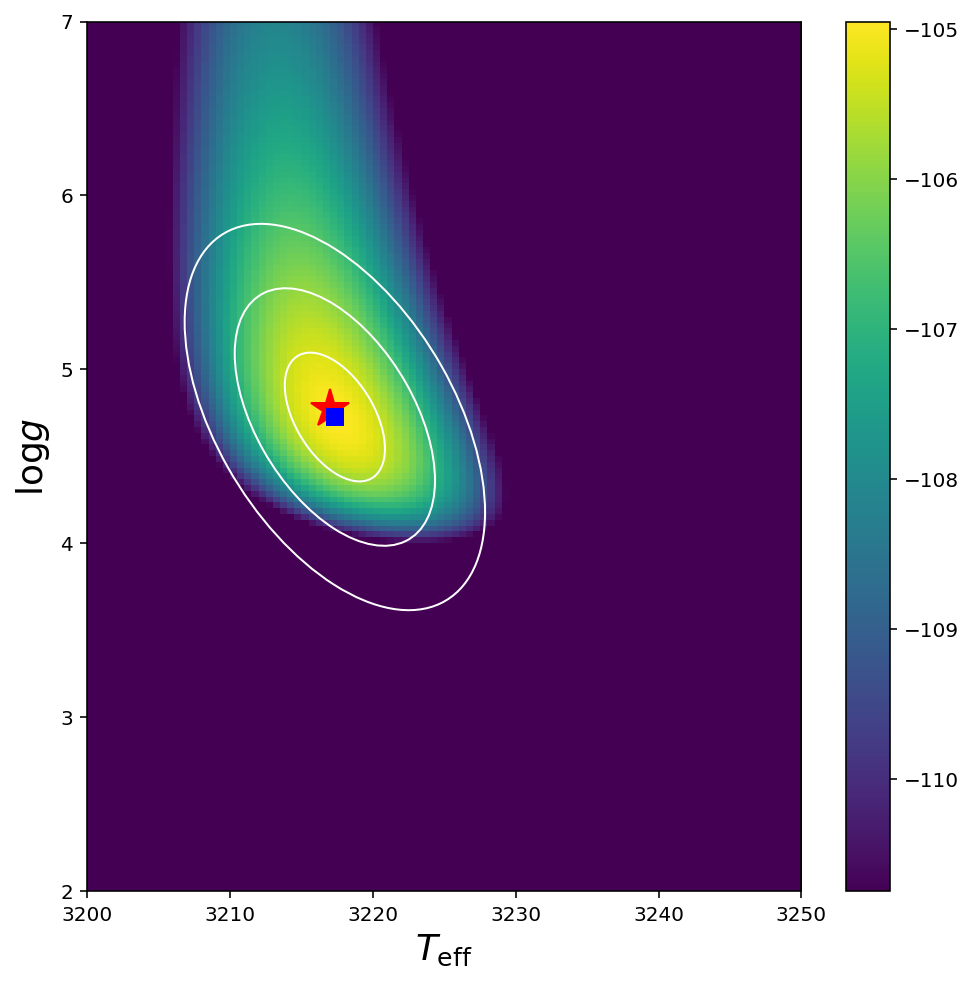

In [41]:
fig, ax = plt.subplots(figsize=(8,8))
plt.plot([true_parameters[0]], [true_parameters[1]], 'r*', ms=20)
plt.plot([mle_estimate[0]], [mle_estimate[1]], 'bs', ms=8,)
cb = ax.imshow(likelihood_grid.T, 
           extent=[teff_vals.min(), teff_vals.max(), logg_vals.min(), logg_vals.max()], 
           aspect='auto',
           vmin=likelihood_grid.max()-5.8, vmax=likelihood_grid.max(), origin='lower');

draw_ellipse(mean, cov, ax=ax, fc='none', ec='w', zorder=10)

plt.xlabel('$T_{\mathrm{eff}}$', fontsize=18)
plt.ylabel('$\log{g}$', fontsize=18)
fig.colorbar(cb);

The chi-squared ellipse contours are approximations to the underlying likelihood surface, which can have more complicated structure.  
Locally, the approximation should be solid.

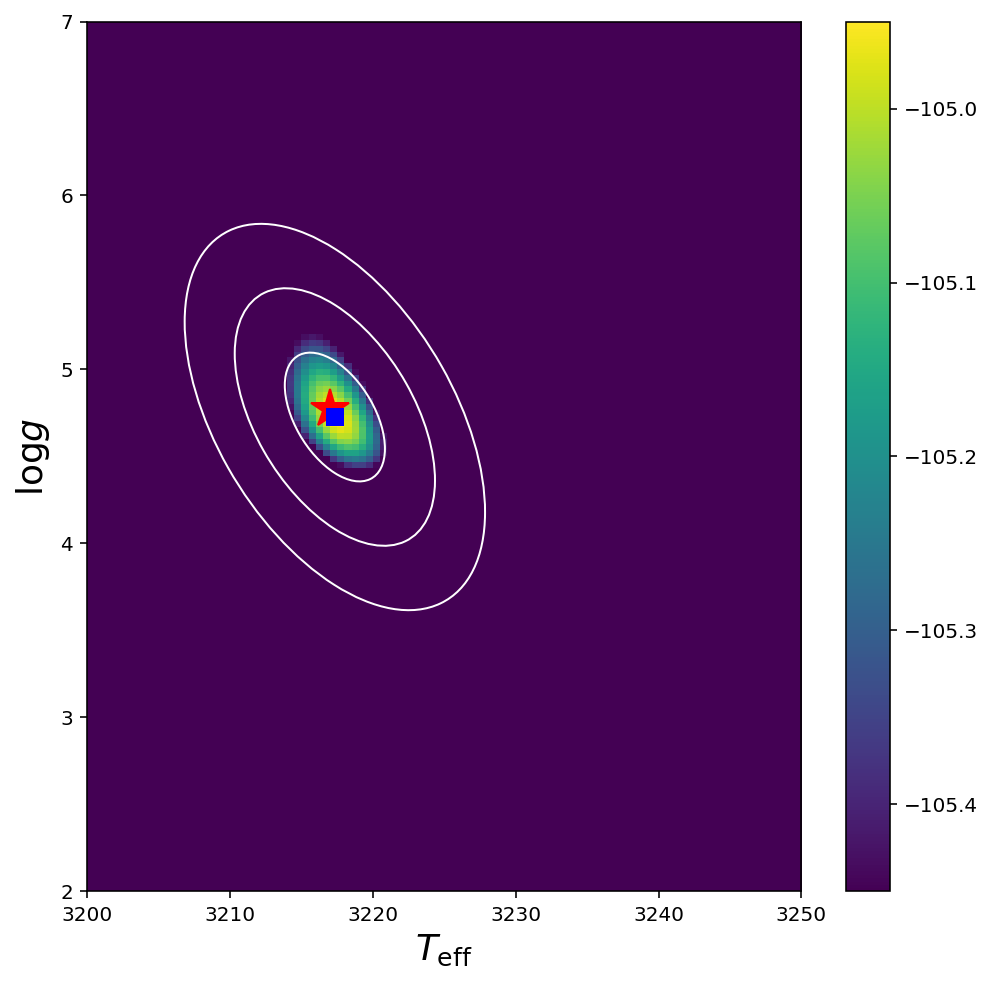

In [43]:
fig, ax = plt.subplots(figsize=(8,8))
plt.plot([true_parameters[0]], [true_parameters[1]], 'r*', ms=20)
plt.plot([mle_estimate[0]], [mle_estimate[1]], 'bs', ms=8,)
cb = ax.imshow(likelihood_grid.T, 
           extent=[teff_vals.min(), teff_vals.max(), logg_vals.min(), logg_vals.max()], 
           aspect='auto',
           vmin=likelihood_grid.max()-0.5, vmax=likelihood_grid.max(), origin='lower');

draw_ellipse(mean, cov, ax=ax, fc='none', ec='w', zorder=10)

plt.xlabel('$T_{\mathrm{eff}}$', fontsize=18)
plt.ylabel('$\log{g}$', fontsize=18)
fig.colorbar(cb);

Thank you to the Jax creators and maintainers for making an awesome tool!